In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from collections import Counter

import pandas as pd
import numpy as np
from scipy import ndimage, signal
from scipy.linalg import cho_solve, solve_triangular

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from world_rowing import api, livetracker, utils, predict

data_store = 'race_data.h5'

In [26]:
with pd.HDFStore(data_store) as store:
    df_names = store.keys()
    races = store['races']
#     events = store['events']
#     competitions = store['competitions']
    race_results = store['race_results'].reset_index(0)
    
# races = utils.merge(
#     (races.reset_index(), events, competitions, api.get_boat_types()),
#     how='left',
#     left_on=('eventId', 'competitionId', 'boatClassId'),
#     right_on='id',
#     suffixes=(
#         (None, '_event'),
#         (None, '_competition'),
#         (None, '_boat_class')
#     )
# )

# races['full_name'] = races.DisplayName_competition.str.cat(
#     [
#         races.DisplayName_event,
#         races.DisplayName
#     ],
#     sep='/'
# )
# race_names = races.set_index('full_name').id

livetracker_names = [
    f for f in df_names if 'livetracker/live_data' in f
]
with pd.HDFStore(data_store) as store:
    livetracker_data = {
        f.split("/")[-1]: store[f] for f in tqdm(livetracker_names)
    }

race_results['total_seconds'] = race_results.ResultTime.dt.total_seconds()
race_class = races.set_index('id').DisplayName_boat_class


  0%|          | 0/372 [00:00<?, ?it/s]

In [36]:
race_results

,race_id,competition_id,boatId,Country,Rank,Lane,ResultTime,total_seconds
id,,,,,,,,
11e97d29-38ae-48c5-a33a-bc9e4ba13944,016189de-a049-48cc-8117-dbaf400911a6,0aa744f5-4224-4f19-8ee4-37bc644ba61a,95c3ad5d-dd33-44ee-b640-efb77d4ac5cf,SUI,4.0,5.0,0 days 00:06:54.360000,414.36
3e0a83f3-4196-4d33-a58f-da609cd644d2,016189de-a049-48cc-8117-dbaf400911a6,0aa744f5-4224-4f19-8ee4-37bc644ba61a,290b2399-24d9-42e6-9a34-67e1d23df7df,CRO,3.0,1.0,0 days 00:06:50.290000,410.29
762c4570-4f0b-44ff-86e0-02620a00257e,016189de-a049-48cc-8117-dbaf400911a6,0aa744f5-4224-4f19-8ee4-37bc644ba61a,bc29fbfa-0223-481e-abfb-df72a03477ed,ITA,1.0,3.0,0 days 00:06:47.520000,407.52
7b23b911-7ec4-4f9a-a428-90bd54bd6c33,016189de-a049-48cc-8117-dbaf400911a6,0aa744f5-4224-4f19-8ee4-37bc644ba61a,e316e26f-b507-4a5b-9fd0-c95cee0508c7,BEL,2.0,4.0,0 days 00:06:49.400000,409.40
982756a9-106e-498a-a16d-861ce11110dc,016189de-a049-48cc-8117-dbaf400911a6,0aa744f5-4224-4f19-8ee4-37bc644ba61a,cdb8c0a7-8c09-484c-b5d8-a269fa88eea0,GBR,5.0,2.0,0 days 00:07:09.960000,429.96
...,...,...,...,...,...,...,...,...
4a9a972d-7c90-4d66-a7a2-7fa31e62da05,fd34aa17-9789-48a4-afb7-9aa2c209757f,e534a1fe-1da7-4dd7-ab42-5e8d9c6807aa,0538fa70-dde4-4b3d-99ac-a7fb1dbc6776,SWE,3.0,2.0,0 days 00:07:02.160000,422.16
597c36c6-4155-41aa-bd2c-875da1288563,fd34aa17-9789-48a4-afb7-9aa2c209757f,e534a1fe-1da7-4dd7-ab42-5e8d9c6807aa,5c2f2aa1-d083-4a7b-951f-8aee50909735,USA,2.0,3.0,0 days 00:07:01.590000,421.59
a902df05-f059-4637-82ab-9b546ff14bb4,fd34aa17-9789-48a4-afb7-9aa2c209757f,e534a1fe-1da7-4dd7-ab42-5e8d9c6807aa,8374e38b-afe2-4155-b375-a3f6bc359e73,ITA,5.0,1.0,0 days 00:07:07.220000,427.22


In [40]:
race_id_results = race_results.set_index('race_id')
    
est_times = {}
rec_times = {}
race_live_data = {}
for race_id, live_data in tqdm(livetracker_data.items()):
    if race_id in race_id_results.index:
        est_times[race_id] = livetracker.estimate_intermediate_times(live_data)[2000]
        rec_times[race_id] = race_id_results.loc[race_id].set_index('Country').total_seconds
        diffs = est_times[race_id] - rec_times[race_id]
        if (abs(diffs.mean()) < 2) and (diffs.std() < 1):
            gmt = api.find_world_best_time(
                boat_class=race_class[race_id]
            ).ResultTime.total_seconds()
            race_live_data[race_id] = livetracker.calculate_pgmts(
                live_data.copy(), gmt
            )
    
live_races = races.loc[
    races.id.isin(race_live_data)
].set_index('id')
    
len(race_live_data)

  0%|          | 0/372 [00:00<?, ?it/s]

200

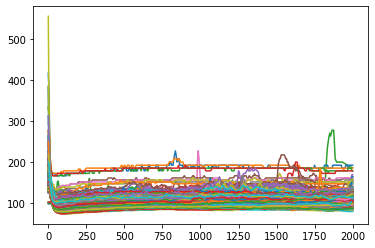

In [41]:
distances = np.linspace(0, 2000, 401).astype(int)
boat_pace = predict.calc_all_boat_pace(race_live_data)
plt.plot(
    distances, boat_pace.values.T
);

<AxesSubplot:ylabel='Density'>

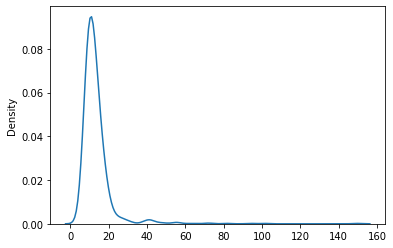

In [42]:
max_variation = np.abs(
    boat_pace.loc[:, 100:].mean(1).values[:, None]
    - boat_pace.loc[:, 100:]
).max(1)
sns.kdeplot(max_variation)

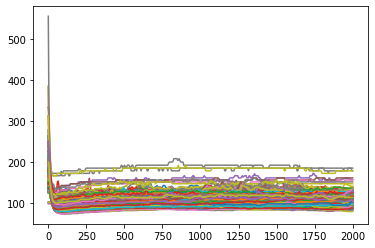

In [43]:
plt.plot(
    distances, boat_pace.loc[max_variation < 30].T
);

# Gaussian Process prediction 

In [44]:
X = boat_pace.loc[max_variation < 30].values
meanX = X.mean(0, keepdims=True)

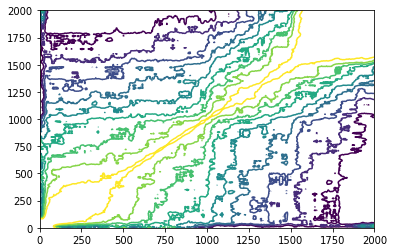

In [45]:
scaledX = X - X.mean(1, keepdims=True)/meanX.mean() * meanX
cov = np.cov(scaledX.T)
plt.contour(
    distances, distances,
    cov,
    np.quantile(cov, np.linspace(0, 1, 11)[1:-1])
)

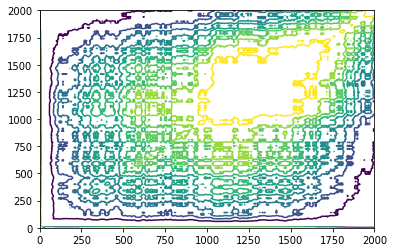

In [46]:
scaledX = X - meanX
cov = np.cov(scaledX.T)
ff = meanX * meanX.T
plt.contour(
    distances, distances,
    cov,
    np.quantile(cov, np.linspace(0, 1, 11)[1:-1])
)

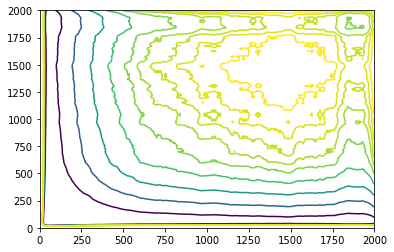

In [47]:
ff = meanX * meanX.T
plt.contour(
    distances, distances,
    ff,
    np.quantile(ff, np.linspace(0, 1, 11)[1:-1])
)

In [48]:
i = 50
x = X[0]
x_fit = distances[:i]
y_fit = x[:i]

f = signal.savgol_filter(meanX, 21,  2)
ff = f * f.T
ff = meanX * meanX.T
Kfull = (ff + cov) + np.eye(len(ff)) * 0.1
# Kfull = ndimage.gaussian_filter(Kfull, sigma=0.1, order=0)
# Kfull = ndimage.gaussian_filter(Kfull, sigma=.3, order=0)
K = Kfull[:i,:i]
L = np.linalg.cholesky(K)
kx = Kfull[i:, :i]
Kxx = Kfull[i:, i:]

y_pred = kx.dot(cho_solve((L, True), y_fit))
S_pred = Kxx - kx.dot(cho_solve((L, True), kx.T))
K2 = linalg.solve_triangular(L, kx.T, lower=True) 
S_pred = Kxx - K2.T.dot(K2)

f, axes = plt.subplots(2, figsize=(12, 10), sharex=True)

axes[0].plot(distances[i:], y_pred)
axes[0].fill_between(
    distances[i:], 
    y_pred + S_pred.diagonal()**0.5, 
    y_pred - S_pred.diagonal()**0.5, 
    alpha=0.5
)
axes[0].plot(distances, x)

times = x.cumsum()/100
triu = np.triu(np.ones_like(S_pred))/100
t_pred = y_pred.dot(triu) + times[i-1]
St = triu.T.dot(S_pred).dot(triu)

axes[1].plot(distances[i:], t_pred - times[i:])
axes[1].fill_between(
    distances[i:], 
    t_pred - times[i:]  - St.diagonal()**0.5, 
    t_pred - times[i:]  + St.diagonal()**0.5,
    alpha=0.5
)
axes[1].plot(distances, np.zeros_like(distances))

NameError: name 'linalg' is not defined

In [635]:
race_id = 'ff750be3-eb69-4b8e-b315-73e0e161eb94'
with pd.HDFStore(data_store) as store:
    live_data = store[f'/livetracker/live_data/{race_id}']
    results = store[f'/livetracker/results/{race_id}']
    intermediates = store[f'/livetracker/intermediates/{race_id}']
    
race_pace = predict.calc_boat_pace(live_data)
race_times = predict.calc_boat_time(live_data)
final_results = results.set_index(
    'DisplayName'
).ResultTime.dt.total_seconds()
intermediate_results = pd.merge(
    intermediates[['raceBoatId', 'distance', 'ResultTime']], 
    results[['id', 'DisplayName']],
    left_on='raceBoatId', 
    right_on='id', 
    how='left'
).set_index(
    ['DisplayName', 'distance']
).ResultTime.dt.total_seconds().unstack()[
    ['d500m', 'd1000m', 'd1500m', 'd2000m']]
intermediate_results

distance,d500m,d1000m,d1500m,d2000m
DisplayName,,,,
CHI,106.72,221.45,339.70,457.45
CHN,108.10,226.11,345.87,465.02
CZE,111.50,227.56,346.50,461.93
IRL1,107.58,223.54,341.49,455.44
IRL2,111.07,226.30,344.93,460.73


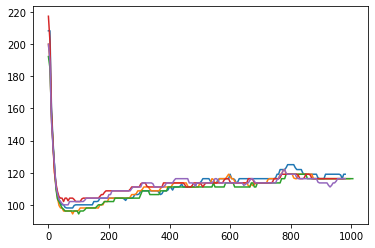

In [1011]:
speed = (
    predicter.calc_distance_data(live_data.loc[:400]).metrePerSecond
)
race_pace = 500/speed
plt.plot(race_pace)

In [1017]:
distances = race_pace.index[
    race_pace.notna().any(1)
]
distances

Int64Index([   0,    5,   10,   15,   20,   25,   30,   35,   40,   45,
            ...
             960,  965,  970,  975,  980,  985,  990,  995, 1000, 1005],
           dtype='int64', name='distance', length=202)

In [1035]:
pred_pace = {}
pred_pace_cov = {}
for cnt, cnt_pace in race_pace.items():
    distance = None or cnt_pace.index[cnt_pace.notna()][-1]
    pace_predictor = predicter.get_linear_pace_predicter(distance)
    pred_pace[cnt] = pace_predictor.dot(cnt_pace.loc[:distance])
    pred_pace_cov[cnt] = predicter.get_pred_pace_cov(distance)
    
pd.DataFrame(pred_pace)

      distance
CHN   0           209.562580
      5           204.933949
      10          160.801811
      15          140.591654
      20          124.779275
                     ...    
IRL2  1980        116.252361
      1985        116.210757
      1990        116.498714
      1995        116.858961
      2000        116.858961
Length: 2005, dtype: float64

In [1041]:
list(pd.concat(pred_pace_cov, axis=1).items())[0]

(('CHN', 0),
 distance
 0       9.399816
 5       0.881582
 10      0.031243
 15     -0.087961
 20     -0.125606
           ...   
 1980   -0.240495
 1985   -0.206361
 1990   -0.203493
 1995   -0.208633
 2000   -0.208633
 Name: (CHN, 0), Length: 401, dtype: float64)

In [1027]:
cnt_pace.index[cnt_pace.notna()][-1]

980

In [1029]:
distance

1500

In [1028]:
cnt_pace.loc[:980]

distance
0      208.333333
5      208.333333
10     161.290323
15     140.186916
20     124.223602
          ...    
960    119.047619
965    118.577075
970    116.279070
975    119.047619
980    119.047619
Name: CHN, Length: 197, dtype: float64

In [1007]:
np.interp?

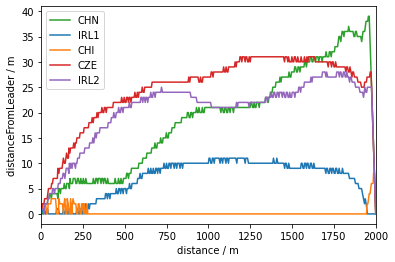

In [844]:
i = 100
noise = 10
distances = np.linspace(0, 2000, 401).astype(int)

ff = meanX * meanX.T
K = pd.DataFrame(
    (ff + cov), 
    index=distances, columns=distances
)

predicter = predict.PredictRace(distances, K)
race_tracker = predict.LivePrediction(
    race_id, predicter, live_data=live_data
)
race_tracker.plot_distance_from_leader()
plt.legend()

In [856]:
for d in tqdm(race_tracker.predicter.distances[::10]):
    race_tracker.predict_win_probability(update=False, distance=d)

  0%|          | 0/41 [00:00<?, ?it/s]

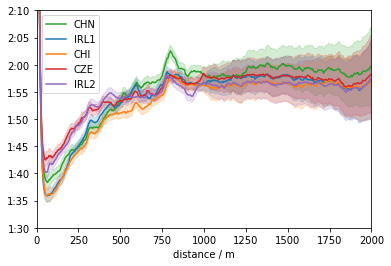

In [853]:
pred_pace, pred_cov = race_tracker.predict_pace(distance=1000)

ax, lines, fills = race_tracker.plot_uncertainty(
    pred_pace.index, 
    pred_pace,
    pred_cov.values.diagonal()**0.5
)
ax.set_ylim(90, 130)
utils.format_yaxis_splits(ax)
plt.legend(lines)

CHN     465.532457
IRL1    459.306500
CHI     455.331859
CZE     463.872794
IRL2    460.386241
Name: 2000, dtype: float64

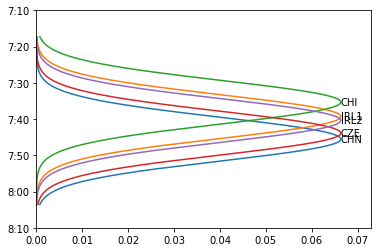

In [898]:
pred_finish, finish_cov = race_tracker.predict_finish_time(
    distance=1000
)
finish_std = finish_cov**0.5

ylim = (pred_finish.min() - 3 * finish_std, 
        pred_finish.max() + 3 * finish_std)
splits = np.linspace(
    *ylim, 1000
)
for cnt, time in pred_finish.items():
    pdf = stats.norm(loc=time, scale=finish_std).pdf(splits)
    plt.plot(
        pdf, 
        splits, 
        label=cnt,
    )
    i = pdf.argmax()
    plt.text(pdf[i], splits[i], cnt, ha='left', va='center')
    

plt.xlim(0, pdf.max()*1.1)
plt.gca().invert_yaxis()
utils.format_yaxis_splits()
# plt.legend()

In [903]:
race_tracker.lane_country

Lane
1     CHN
2    IRL1
3     CHI
4     CZE
5    IRL2
Name: Country, dtype: object

country
IRL1    #1f77b4
CHI     #ff7f0e
CHN     #2ca02c
CZE     #d62728
IRL2    #9467bd
Name: color, dtype: object

[Text(1, 0, 'CHN'),
 Text(2, 0, 'IRL1'),
 Text(3, 0, 'CHI'),
 Text(4, 0, 'CZE'),
 Text(5, 0, 'IRL2')]

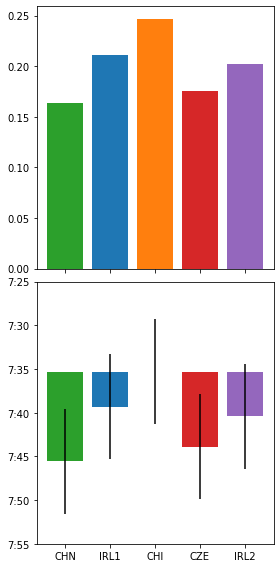

In [964]:
distance=1000
pred_finish, finish_cov = race_tracker.predict_finish_time(
    distance=distance
)
finish_std = finish_cov**0.5
win_prob = race_tracker.predict_win_probability(
    distance=distance
)
f, axes = plt.subplots(2, figsize=(4, 8), sharex=True)

race_tracker.bar(
    win_prob, 
    ax=axes[0])
race_tracker.bar(
    pred_finish - pred_finish.min(), 
    bottom=pred_finish.min(), 
    yerr=finish_std,
    ax=axes[1])

axes[1].invert_yaxis()
utils.format_yaxis_splits(axes[1])

f.tight_layout()
f.subplots_adjust(hspace=0.05)

axes[1].get_xticklabels()

In [999]:

race_tracker.plot_finish_times(
    pred_finish, finish_cov**0.5, ax=axes[0])

(<AxesSubplot:>,
 {'CHN': <matplotlib.collections.PolyCollection at 0x7f3feb120700>,
  'IRL1': <matplotlib.collections.PolyCollection at 0x7f3feb120e80>,
  'CHI': <matplotlib.collections.PolyCollection at 0x7f3feb138640>,
  'CZE': <matplotlib.collections.PolyCollection at 0x7f3febe44820>,
  'IRL2': <matplotlib.collections.PolyCollection at 0x7f3feb138b50>},
 {'CHN': [<matplotlib.lines.Line2D at 0x7f3feb120670>],
  'IRL1': [<matplotlib.lines.Line2D at 0x7f3feb120df0>],
  'CHI': [<matplotlib.lines.Line2D at 0x7f3feb1385b0>],
  'CZE': [<matplotlib.lines.Line2D at 0x7f3fec3d9a30>],
  'IRL2': [<matplotlib.lines.Line2D at 0x7f3feb138a60>]})

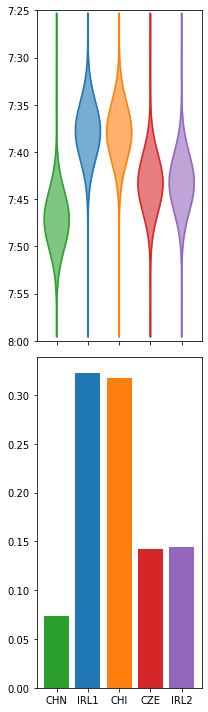

In [1046]:
distance=1500
pred_finish, finish_cov = race_tracker.predict_finish_time(
    distance=distance
)
win_probs = race_tracker.predict_win_probability(
    distance=distance
)
f, axes = plt.subplots(2, figsize=(3, 10), sharex=True)

race_tracker.plot_finish_times(
    pred_finish, finish_cov**0.5, ax=axes[0])
race_tracker.bar(
    win_probs, ax=axes[1])
f.tight_layout()
f.subplots_adjust(hspace=0.05)

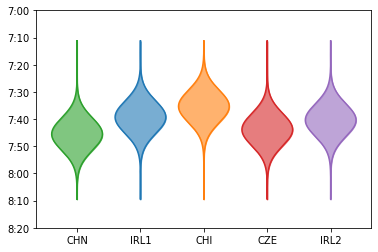

In [984]:
distance=1000
pred_finish, finish_cov = race_tracker.predict_finish_time(
    distance=distance
)

ylim = (pred_finish.min() - 4 * finish_std, 
        pred_finish.max() + 4 * finish_std)
y = np.linspace(*ylim, 1000)
y_dens = pd.DataFrame({
    cnt: stats.norm(
        loc=pred_finish[cnt], 
        scale=finish_std
    ).pdf(y)
    for cnt in race_tracker.lane_country
}, 
    index=y
)

ax, vs, ls = race_tracker.violin(y_dens)
ax.invert_yaxis()
utils.format_yaxis_splits(ax)

In [979]:
ax.set_xticklabels?

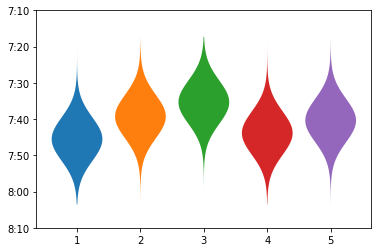

In [971]:
distance=1000
pred_finish, finish_cov = race_tracker.predict_finish_time(
    distance=distance
)

ylim = (pred_finish.min() - 3 * finish_std, 
        pred_finish.max() + 3 * finish_std)

width = 0.8
x = race_tracker.lane_country.index
y = np.linspace(
    *ylim, 1000
)
y_dens = pd.DataFrame({
    cnt: stats.norm(
        loc=pred_finish[cnt], 
        scale=finish_std
    ).pdf(y)
    for cnt in race_tracker.lane_country
}, 
    index=y
)

y_scale = y_dens.max(0)
y_dens_p = y_dens / y_scale * width /2

ax = plt.gca()

for x0, cnt in race_tracker.lane_country.items():
    ax.fill_betweenx(
        y, 
        -y_dens_p[cnt] + x0,
        y_dens_p[cnt] + x0,
    )
    

ax.invert_yaxis()
utils.format_yaxis_splits(ax)

In [969]:
(y_dens[cnt] + x0).max()

5.066352022754121

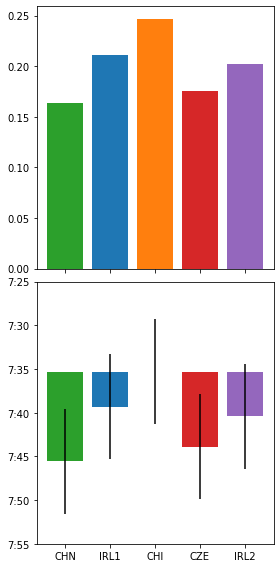

In [939]:
f, axes = plt.subplots(2, figsize=(4, 8), sharex=True)

axes[0].bar(
    race_tracker.lane_country.index,
    win_prob[race_tracker.lane_country],
    tick_label=race_tracker.lane_country,
    color=race_tracker.country_colors[race_tracker.lane_country]
)

axes[1].bar(
    race_tracker.lane_country.index,
    pred_finish[race_tracker.lane_country] - pred_finish.min(),
    bottom=pred_finish.min(),
    yerr=finish_std, 
    tick_label=race_tracker.lane_country,
    color=race_tracker.country_colors[race_tracker.lane_country]
)
axes[1].invert_yaxis()
utils.format_yaxis_splits(axes[1])

f.tight_layout()
f.subplots_adjust(hspace=0.05)

In [943]:
axes[0].get_xlim()

(0.36, 5.64)

In [946]:
axes[1].get_xticklabels()

[Text(1, 0, 'CHN'),
 Text(2, 0, 'IRL1'),
 Text(3, 0, 'CHI'),
 Text(4, 0, 'CZE'),
 Text(5, 0, 'IRL2')]

In [929]:
pred_finish.min(), pred_finish.min()

(455.3318585759265, 455.3318585759265)

In [875]:
    columns = [
        'distanceFromLeader', 'strokeRate', 
        'metrePerSecond', 'PGMT'
    ]
    dist_travelled = live_data.distanceTravelled
    boat_lims = {
        cnt: dist_travelled[cnt].searchsorted(distances[-1]) + 1
        for cnt in dist_travelled.columns
    }
    parse_cols = live_data[columns].columns
    live_dist_data = pd.DataFrame(
        np.vstack(
            [
                np.interp(
                    distances, 
                    dist_travelled.loc[:boat_lims[cnt], cnt],
                    live_data.loc[:boat_lims[cnt], (col, cnt)]
                )
                for (col, cnt) in parse_cols
            ]
        ).T,
        columns=parse_cols,
        index=distances
    )
    live_dist_data

distanceFromLeader                                       strokeRate  \
                    CHN      IRL1       CHI    CZE       IRL2        CHN   
0              0.000000  1.000000  1.000000   1.00   1.000000   0.000000   
5              0.000000  1.000000  1.000000   1.25   1.000000   0.000000   
10             0.000000  0.833333  1.250000   2.00   1.000000  46.000000   
15             1.666667  0.000000  1.666667   2.00   0.833333  45.000000   
20             1.250000  0.833333  1.250000   2.50   0.000000  45.000000   
...                 ...       ...       ...    ...        ...        ...   
1980          20.000000  0.000000  6.000000  20.00  20.000000  38.153846   
1985          15.000000  0.000000  6.666667  15.00  15.000000  37.400000   
1990          10.000000  0.000000  8.000000  10.00  10.000000  37.000000   
1995           5.000000  0.000000  5.000000   5.00   5.000000  37.000000   
2000           0.000000  0.000000  0.000000   0.00   0.000000  37.000000   

                                                 metrePerSecond            \
           IRL1        CHI        CZE       IRL2            CHN      IRL1   
0      0.000000   0.000000   0.000000   0.000000       2.400000  2.500000   
5      9.800000   9.400000  11.250000   9.400000       2.400000  2.640000   
10    48.833333  47.000000  44.600000  47.000000       3.100000  3.266667   
15    48.000000  47.333333  44.000000  47.166667       3.566667  3.600000   
20    49.000000  48.000000  44.000000  48.000000       4.025000  4.166667   
...         ...        ...        ...        ...            ...       ...   
1980  41.000000  37.000000  37.000000  39.000000       3.930769  4.500000   
1985  41.000000  37.000000  36.642857  39.000000       3.900000  4.500000   
1990  40.000000  37.000000  36.285714  39.000000       3.900000  4.400000   
1995  40.000000  36.625000  36.000000  39.000000       3.900000  4.400000   
2000  40.000000  36.000000  36.000000  39.000000       3.900000  4.300000   

                                        PGMT                                \
           CHI       CZE      IRL2       CHN      IRL1       CHI       CZE   
0     2.600000  2.300000  2.500000  0.597307  0.477846  0.477846  0.477846   
5     2.700000  2.475000  2.640000  0.597307  0.495595  0.495595  0.484293   
10    3.200000  3.160000  3.280000  0.629545  0.584315  0.570745  0.535466   
15    3.633333  3.640000  3.666667  0.607635  0.672935  0.607635  0.598700   
20    4.025000  4.150000  4.000000  0.663497  0.671080  0.663497  0.638350   
...        ...       ...       ...       ...       ...       ...       ...   
1980  3.900000  4.200000  4.400000  0.882546  0.901293  0.898452  0.888214   
1985  3.866667  4.164286  4.400000  0.882146  0.901198  0.898155  0.888050   
1990  3.800000  4.128571  4.400000  0.881829  0.901080  0.897652  0.887886   
1995  3.725000  4.083333  4.400000  0.881596  0.901352  0.897442  0.887752   
2000  3.600000  4.000000  4.400000  0.881363  0.901200  0.897186  0.887739   

                
          IRL2  
0     0.477846  
5     0.495595  
10    0.578887  
15    0.638567  
20    0.691038  
...        ...  
1980  0.889976  
1985  0.890035  
1990  0.890165  
1995  0.890296  
2000  0.890426  

[401 rows x 20 columns]

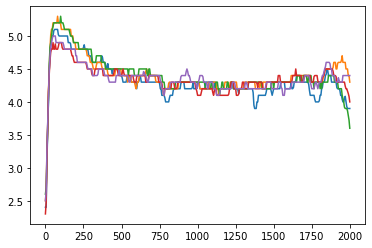

In [880]:
plt.plot(live_dist_data.metrePerSecond)

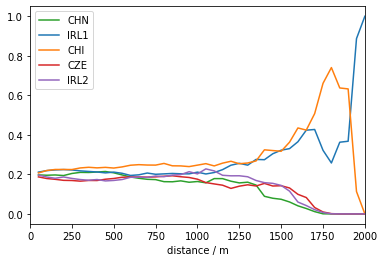

In [857]:
win_preds = pd.concat(race_tracker.win_preds).unstack().sort_index()
race_tracker.plot(
    win_preds.index, win_preds
)
plt.legend()

In [865]:
pred_finish, std = race_tracker.predict_finish_time(distance=1100)
pred_finish

CHN     464.124803
IRL1    461.235493
CHI     458.437533
CZE     467.014411
IRL2    460.516337
Name: 2000, dtype: float64

In [866]:
pred_finish.apply(utils.format_totalseconds)

CHN     7:44.12
IRL1    7:41.23
CHI     7:38.43
CZE     7:47.01
IRL2    7:40.51
Name: 2000, dtype: object

In [861]:
race_tracker.race_boats

,raceId,id,boatId,Country,Rank,Lane,ResultTime
0,ff750be3-eb69-4b8e-b315-73e0e161eb94,0714193b-8a41-49b8-912f-f931a3858996,3c411ec5-e1e4-4ede-b8f2-57cd9f75489f,IRL1,1,2,0 days 00:07:35.440000
1,ff750be3-eb69-4b8e-b315-73e0e161eb94,6d3599b0-575c-49a2-a5f4-fd71071bf3a1,4ac763d7-2c13-483a-9710-bc051489ef1b,CHI,2,3,0 days 00:07:37.450000
2,ff750be3-eb69-4b8e-b315-73e0e161eb94,83e9e3c7-2d72-41ae-a8f2-f79a8f59cd14,96a52dc0-d4f4-4939-b04e-8ce9da48b5b0,CHN,5,1,0 days 00:07:45.020000
3,ff750be3-eb69-4b8e-b315-73e0e161eb94,f1092321-89e4-4555-9954-f09ff47c6eb1,e8264f19-528c-4a96-85a8-3a397b1a2a6d,CZE,4,4,0 days 00:07:41.930000
4,ff750be3-eb69-4b8e-b315-73e0e161eb94,f61d7d38-97f2-4e40-b961-76ddfb7d9524,1e5b8cad-49f6-4810-8b3a-637ce5bee5a4,IRL2,3,5,0 days 00:07:40.730000


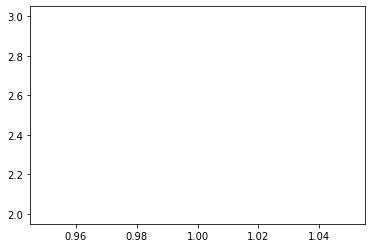

In [834]:
plt.fill_between([1],[2], [3])

In [773]:
pred_times, pred_times_cov = race_tracker.predict_times()
pred_times_std = pd.Series(
    pred_times_cov.values.diagonal()**0.5,
    index=pred_times.index
)

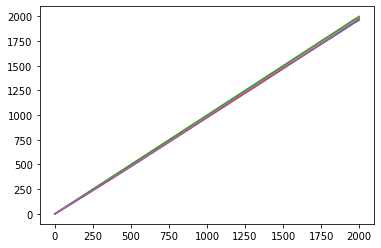

In [784]:
plt.plot(
    predict.estimate_distance_from_leader(pred_times)
)

In [782]:
np.interp?

In [783]:
pd.DataFrame(
    np.vstack([
        np.interp(
            leader_times,
            pred_times[cnt],
            leader_times.index, 
        )
        for cnt in pred_times.columns
    ]).T,
    columns=pred_times.columns,
    index=leader_times.index
)

,CHN,IRL1,CHI,CZE,IRL2
distance,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000
5,4.099986,4.678044,5.000000,3.946112,4.675501
10,8.693311,9.653398,10.000000,8.575289,9.681872
15,13.434060,14.677861,15.000000,13.395461,14.715082
20,18.191576,19.730834,20.000000,18.231565,19.700119
...,...,...,...,...,...
1980,1942.488691,1980.000000,1976.064510,1954.099192,1956.978591
1985,1947.080299,1985.000000,1980.256502,1958.881512,1961.876683
1990,1951.687183,1990.000000,1984.375901,1963.693155,1966.829985


In [777]:
leader_times

distance
0         1.927981
5         3.777686
10        5.333375
15        6.722809
20        7.963543
           ...    
1980    451.735485
1985    452.854909
1990    453.984955
1995    455.125690
2000    456.266426
Length: 401, dtype: float64

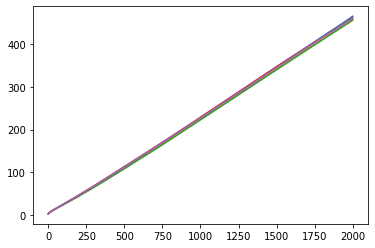

In [774]:
plt.plot(pred_times)

In [747]:
race_tracker.live_data.distanceFromLeader

,CHN,IRL1,CHI,CZE,IRL2
0,0,1,1,1,1
1,0,1,1,1,1
2,0,1,1,2,1
3,0,1,1,2,1
4,2,0,2,2,1
...,...,...,...,...,...
803,18,0,0,6,0
804,13,0,0,0,0
805,13,0,0,0,0
806,0,0,0,0,0


In [733]:
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = prop_cycle.by_key()['color']
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [732]:
race_tracker.race_boats

,raceId,id,boatId,Country,Rank,Lane,ResultTime
0,ff750be3-eb69-4b8e-b315-73e0e161eb94,0714193b-8a41-49b8-912f-f931a3858996,3c411ec5-e1e4-4ede-b8f2-57cd9f75489f,IRL1,1,2,0 days 00:07:35.440000
1,ff750be3-eb69-4b8e-b315-73e0e161eb94,6d3599b0-575c-49a2-a5f4-fd71071bf3a1,4ac763d7-2c13-483a-9710-bc051489ef1b,CHI,2,3,0 days 00:07:37.450000
2,ff750be3-eb69-4b8e-b315-73e0e161eb94,83e9e3c7-2d72-41ae-a8f2-f79a8f59cd14,96a52dc0-d4f4-4939-b04e-8ce9da48b5b0,CHN,5,1,0 days 00:07:45.020000
3,ff750be3-eb69-4b8e-b315-73e0e161eb94,f1092321-89e4-4555-9954-f09ff47c6eb1,e8264f19-528c-4a96-85a8-3a397b1a2a6d,CZE,4,4,0 days 00:07:41.930000
4,ff750be3-eb69-4b8e-b315-73e0e161eb94,f61d7d38-97f2-4e40-b961-76ddfb7d9524,1e5b8cad-49f6-4810-8b3a-637ce5bee5a4,IRL2,3,5,0 days 00:07:40.730000


In [715]:
race_tracker.live_data.metrePerSecond

,CHN,IRL1,CHI,CZE,IRL2
0,2.4,2.5,2.6,2.3,2.5
1,2.4,2.5,2.6,2.3,2.5
2,3.1,3.2,3.1,3.0,3.2
3,3.1,3.2,3.1,3.0,3.2
4,3.4,3.6,3.5,3.4,3.6
...,...,...,...,...,...
803,3.9,4.2,3.4,4.1,4.4
804,3.9,4.2,3.1,4.0,4.4
805,3.9,4.2,3.1,4.0,4.4
806,3.9,4.2,2.4,3.7,4.3


In [722]:
api.get_race_results(race_id=race_id)

boatId  \
raceId                               id                                                                           
ff750be3-eb69-4b8e-b315-73e0e161eb94 0714193b-8a41-49b8-912f-f931a3858996  3c411ec5-e1e4-4ede-b8f2-57cd9f75489f   
                                     6d3599b0-575c-49a2-a5f4-fd71071bf3a1  4ac763d7-2c13-483a-9710-bc051489ef1b   
                                     83e9e3c7-2d72-41ae-a8f2-f79a8f59cd14  96a52dc0-d4f4-4939-b04e-8ce9da48b5b0   
                                     f1092321-89e4-4555-9954-f09ff47c6eb1  e8264f19-528c-4a96-85a8-3a397b1a2a6d   
                                     f61d7d38-97f2-4e40-b961-76ddfb7d9524  1e5b8cad-49f6-4810-8b3a-637ce5bee5a4   

                                                                          Country  \
raceId                               id                                             
ff750be3-eb69-4b8e-b315-73e0e161eb94 0714193b-8a41-49b8-912f-f931a3858996    IRL1   
                                     6d3599b0-575c-49a2-a5f4-fd71071bf3a1     CHI   
                                     83e9e3c7-2d72-41ae-a8f2-f79a8f59cd14     CHN   
                                     f1092321-89e4-4555-9954-f09ff47c6eb1     CZE   
                                     f61d7d38-97f2-4e40-b961-76ddfb7d9524    IRL2   

                                                                           Rank  \
raceId                               id                                           
ff750be3-eb69-4b8e-b315-73e0e161eb94 0714193b-8a41-49b8-912f-f931a3858996     1   
                                     6d3599b0-575c-49a2-a5f4-fd71071bf3a1     2   
                                     83e9e3c7-2d72-41ae-a8f2-f79a8f59cd14     5   
                                     f1092321-89e4-4555-9954-f09ff47c6eb1     4   
                                     f61d7d38-97f2-4e40-b961-76ddfb7d9524     3   

                                                                           Lane  \
raceId                               id                                           
ff750be3-eb69-4b8e-b315-73e0e161eb94 0714193b-8a41-49b8-912f-f931a3858996     2   
                                     6d3599b0-575c-49a2-a5f4-fd71071bf3a1     3   
                                     83e9e3c7-2d72-41ae-a8f2-f79a8f59cd14     1   
                                     f1092321-89e4-4555-9954-f09ff47c6eb1     4   
                                     f61d7d38-97f2-4e40-b961-76ddfb7d9524     5   

                                                                                      ResultTime  
raceId                               id                                                           
ff750be3-eb69-4b8e-b315-73e0e161eb94 0714193b-8a41-49b8-912f-f931a3858996 0 days 00:07:35.440000  
                                     6d3599b0-575c-49a2-a5f4-fd71071bf3a1 0 days 00:07:37.450000  
                                     83e9e3c7-2d72-41ae-a8f2-f79a8f59cd14 0 days 00:07:45.020000  
                                     f1092321-89e4-4555-9954-f09ff47c6eb1 0 days 00:07:41.930000  
                                     f61d7d38-97f2-4e40-b961-76ddfb7d9524 0 days 00:07:40.730000

In [721]:
race_tracker.race_details

eventId            529f3304-b139-4672-abf5-2ac74842a03b
racePhaseId        0959f5e8-f85a-40fb-93ab-b6c477f6aade
raceStatusId       182f6f15-8e78-41c3-95b3-8b006af2c6a1
genderId           dae73748-90c9-4a49-9d94-4d4810fa457e
RscCode              ROWWNOCOX2------------REP-000100--
DisplayName                      Women's Pair Repechage
RaceNr                                               60
IsStarted                                          None
Date                                2021-05-22 09:00:00
DateString                    2021-05-22T11:00:00+02:00
Progression                                     1-4->FA
Rescheduled                                        None
RescheduledFrom                                    None
Name: ff750be3-eb69-4b8e-b315-73e0e161eb94, dtype: object

In [622]:
predicter.predict_finish_times(race_pace, distance=250)

(distance
 CHN     450.197409
 IRL1    443.495006
 CHI     442.731492
 CZE     465.094513
 IRL2    460.453989
 Name: 2000, dtype: float64,
 114.99722800576241)

In [623]:
final_results

DisplayName
CHN     465.02
IRL1    455.44
CHI     457.45
CZE     461.93
IRL2    460.73
Name: ResultTime, dtype: float64

In [422]:
i = 100
noise = 0.1
distances = np.linspace(0, 2000, 401).astype(int)

ff = meanX * meanX.T
K = pd.DataFrame(
    (ff + cov), 
    index=distances, columns=distances
)
L = pd.DataFrame(
    np.linalg.cholesky(K + np.eye(len(K)) * noise),
    index=K.index,
    columns=K.columns, 
) 
boat_preds = {
    cnt: predict.predict_pace_time(
        distances, pace, K, L
    )
    for cnt, pace in race_pace.iterrows()
}

In [452]:
class PredictRace:
    def __init__(self, distances, K, noise=10.):
        self.distances = pd.Index(distances, name='distance')
        # Distance travelled between each distance
        # Needed to calculate times
        deltam = np.diff(self.distances)    
        deltam = np.r_[deltam, deltam[0]]
        self.delta_dist = pd.Series(
            deltam, index=self.distances
        )
        # covariance matrix
        self.K = pd.DataFrame(
            K, 
            index=self.distances,
            columns=self.distances
        )
        # Cholesky factorisation of covariance matrix with noise
        self.L = pd.DataFrame(
            np.linalg.cholesky(
                K + np.eye(len(K)) * noise
            ),
            index=K.index,
            columns=K.columns, 
        )
        # linear transform to calculate predicted times
        self.pace_time_M = pd.DataFrame(
            np.tril(
                np.ones_like(K) 
                * (self.delta_dist.values[:, None]/500)
            ),
            index=self.distances,
            columns=self.distances
        )
        # cached inverses
        self.pace_predicters = {}
        self.pred_pace_covs = {}
        
    def calc_predicters(self, distance):
        x = self.distances
        X = pace.loc[:distance].index
        kxX = self.K.loc[x, X]
        LXX = self.L.loc[X, X]
        pace_predicter = pd.DataFrame(
            linalg.cho_solve((LXX, True), kxX.T).T,
            index=self.distances, 
            columns=LXX.index,
        )
        self.pace_predicters[distance] = pace_predicter
        
        Kkh = linalg.solve_triangular(
            LXX, kxX.T, lower=True
        )
        pred_pace_cov = pd.DataFrame(
            kxx - Kkh.T.dot(Kkh),
            index=kxx.index, columns=kxx.columns
        )
        self.pred_pace_covs[distance] = pred_pace_cov
        
        return pace_predicter, pred_pace_cov
        
    def get_linear_pace_predicter(self, distance):
        if distance not in self.pace_predicters:
            self.calc_predicters(distance)
            
        return self.pace_predicters[distance]
    
    def get_pred_pace_cov(self, distance):
        if distance not in self.pred_pace_covs:
            self.calc_predicters(distance)
            
        return self.pred_pace_covs[distance]
    
    def predict_pace(self, race_pace, distance=None):
        distance = distance or race_pace.index[-1]
        pace_predictor = self.get_linear_pace_predicter(distance)
        pred_pace = pace_predictor.dot(race_pace.loc[:distance])
        pred_pace_cov = self.get_pred_pace_cov(distance)
        return pred_pace, pred_pace_cov
    
    def predict_time(
            self, race_pace, distance=None, 
            pred_pace=None, pred_pace_cov=None
    ):
        if pred_pace is None or pred_pace_cov is None:
            pred_pace, pred_pace_cov = self.predict_pace(
                race_pace, distance)
            
        M = predicter.pace_time_M
        pred_times = M.dot(pred_pace)
        pred_time_cov = M.dot(pred_pace_cov.dot(M.T))
        
        return pred_times, pred_time_cov
        
        
predicter = PredictRace(distances, K, noise=10)

pred_pace, pred_pace_cov = \
    predicter.predict_pace(race_pace.T, distance=250)
pred_time = predicter.pace_time_M.dot(pred_pace)
pred_time_cov = predicter.pace_time_M.dot(
    pred_pace_cov.dot(predicter.pace_time_M.T)
)


3.1084985924153155


,pred,win_prob,actual
CHN,9.399008,0.00,9.58
IRL1,0.000000,0.52,0.00
CHI,0.126773,0.48,2.01
CZE,5.547616,0.00,6.49
IRL2,5.480632,0.00,5.29


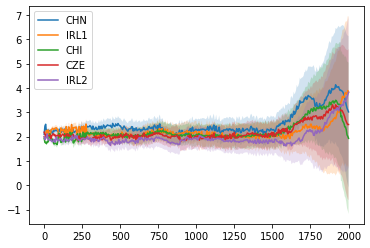

In [505]:
pred_time, pred_time_cov = \
    predicter.predict_time(race_pace.T, distance=1500)
pred_time_std = pred_time_cov.values.diagonal()**0.5

for col in pred_time.columns:
    diff = pred_time[col] - race_time.loc[col]
    plt.plot(
        diff,
        label=col
    )
    plt.fill_between(
        diff.index, 
        diff - pred_time_std,
        diff + pred_time_std,
        alpha=0.2
    )
plt.legend()

pred_finish = pred_time.loc[2000]
print(pred_time_std[-1])

ps = pred_finish.values[:, None]
probs = pd.DataFrame(
    Phi(
        (ps - ps.T) / pred_time_std[-1]
    ),
    index=pred_finish.index, 
    columns=pred_finish.index
)
prob_win = probs.prod(axis=0)
prob_win /= prob_win.sum()
prob_win

final_preds = pd.DataFrame({
    'pred': pred_finish - pred_finish.min(),
    'win_prob': prob_win.round(2),
    'actual': final_results - final_results.min()
})
final_preds

In [591]:
predict.calc_win_probs(pred_finish, pred_time_std[-1]).round(4)

country
CHN     0.0000
IRL1    0.5357
CHI     0.4643
CZE     0.0000
IRL2    0.0000
dtype: float64

In [515]:
diffs = pred_finish - pred_finish.min()
diffs

country
CHN     9.399008
IRL1    0.000000
CHI     0.126773
CZE     5.547616
IRL2    5.480632
Name: 2000, dtype: float64

In [518]:
Phi(diffs - 1)

country
CHN     1.000000
IRL1    0.158655
CHI     0.191270
CZE     0.999997
IRL2    0.999996
Name: 2000, dtype: float64

In [576]:
def func(x, diffs, std):
    logcdf = -stats.norm.logcdf((x - diffs), loc=std)
    logcdf -= logcdf.sum()
    logp = stats.norm.logpdf((x - diffs), loc=std)
    return np.exp(logp + logcdf)

res, err = integrate.quad_vec(
    lambda x: func(
        x, np.r_[-1, 1], 1
    ), 
    -np.inf, np.inf,
)
res, res.sum()

(array([0.0786496, 0.9213504]), 1.0000000000000002)

In [582]:
%%timeit 
res, err = integrate.quad_vec(
    lambda x: func(x, -diffs+100, std), 
    -np.inf, np.inf,
#     workers=4, 
)
res.round(3), res.sum()

21.4 ms ± 5.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [585]:
res.round(4)

array([0.    , 0.5357, 0.4643, 0.    , 0.    ])

In [574]:
res.round(3), res.sum()

(array([0.994, 0.   , 0.   , 0.003, 0.003]), 0.9999999999999997)

In [558]:
func(2, diffs, std)

array([9.34628532e-39, 2.93796899e-08, 1.30487828e-08, 3.15508872e-24,
       5.10420870e-24])

In [534]:
x = 100
cdf = Phi((diffs - x)/std)
cdf.prod() / cdf

<ipython-input-534-22a0510915d8>:3: RuntimeWarning: invalid value encountered in true_divide
  cdf.prod() / cdf


array([nan, nan, nan, nan, nan])

In [544]:
func(1000, diffs, std)

<ipython-input-539-b5d7fa1d6f71>:4: RuntimeWarning: invalid value encountered in true_divide
  p = stats.norm.pdf((x - diffs)/std)/cdf


array([nan, nan, nan, nan, nan])

(array([1.38143252e-38, 7.95472433e-06, 3.48302949e-06, 7.92166094e-23,
        1.36333561e-22]),
 4.0906259647885954e-15)

In [521]:
stats.norm.pdf((diffs - 1))

array([1.91698667e-16, 2.41970725e-01, 2.72477047e-01, 1.28863008e-05,
       1.74360543e-05])

In [514]:
integrate.quad?

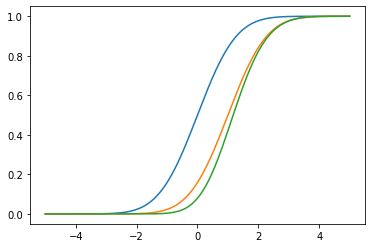

In [508]:
x = np.linspace(-5, 5, 1000)

plt.plot(x, Phi(x))
plt.plot(x, Phi(x - 1))
plt.plot(x, Phi(x) * Phi(x-1))

In [469]:
np.sqrt(2)

1.4142135623730951

In [420]:
race_pace = predict.calc_boat_pace(live_data)
race_time = predict.calc_boat_time(live_data)
race_time[1995], race_time[2000]

(country
 CHN     462.862620
 IRL1    452.716870
 CHI     454.689547
 CZE     459.652150
 IRL2    458.338611
 Name: 1995, dtype: float64,
 country
 CHN     464.144671
 IRL1    453.927954
 CHI     455.958869
 CZE     460.811338
 IRL2    459.420312
 Name: 2000, dtype: float64)

In [406]:
results.set_index('DisplayName').ResultTime.dt.total_seconds()

DisplayName
CHN     465.02
IRL1    455.44
CHI     457.45
CZE     461.93
IRL2    460.73
Name: ResultTime, dtype: float64

In [401]:
pred_time_cov.values.diagonal()**0.5

array([ 0.03068305,  0.04382713,  0.05184962,  0.05999609,  0.06716352,
        0.07394274,  0.07978247,  0.08470922,  0.08932937,  0.09372788,
        0.09796707,  0.10207343,  0.10609316,  0.11027194,  0.11392939,
        0.11718607,  0.12103746,  0.12501253,  0.1286805 ,  0.13220831,
        0.13559332,  0.13876089,  0.14188037,  0.14502657,  0.14808131,
        0.15116394,  0.1542054 ,  0.1572259 ,  0.16018033,  0.16298062,
        0.16570446,  0.168473  ,  0.17113883,  0.17384004,  0.17662201,
        0.17931701,  0.182123  ,  0.18489844,  0.18765118,  0.19040604,
        0.19307461,  0.19577917,  0.19862306,  0.20152353,  0.20452456,
        0.20765887,  0.21093494,  0.21429416,  0.21782896,  0.2215808 ,
        0.22576264,  0.23057269,  0.23601089,  0.24212532,  0.24904665,
        0.25629267,  0.26368239,  0.27145229,  0.27964797,  0.28839099,
        0.29773248,  0.30783216,  0.31843225,  0.32957177,  0.3413095 ,
        0.35357044,  0.36616432,  0.3790404 ,  0.39207724,  0.40

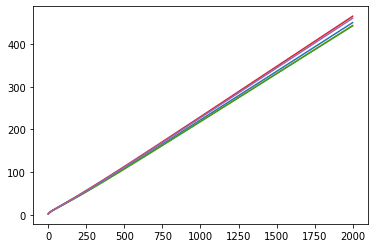

In [397]:
plt.plot(
    pred_time
)

In [391]:
pred_pace

country,CHN,IRL1,CHI,CZE,IRL2
distance,,,,,
0,209.848164,200.559597,192.908951,218.134909,200.540744
5,204.315854,189.257552,184.560991,202.120841,189.255167
10,160.771613,153.871671,155.613321,158.090448,153.197227
15,140.832701,136.976817,138.451672,138.409159,136.919834
20,125.168878,122.054866,123.790269,123.327543,123.938333
...,...,...,...,...,...
1980,114.374029,112.687687,112.558858,117.544402,116.538483
1985,114.538368,112.892493,112.760290,117.722595,116.700025
1990,114.805353,113.161482,113.035669,117.954952,116.966993


In [390]:
predicter.triu.dot(pred_pace)

country,CHN,IRL1,CHI,CZE,IRL2
distance,,,,,
0,450.197409,443.495006,442.731492,465.094513,460.453989
5,448.098927,441.489410,440.802403,462.913164,458.448582
10,446.055769,439.596834,438.956793,460.891955,456.556030
15,444.448053,438.058117,437.400660,459.311051,455.024058
20,443.039726,436.688349,436.016143,457.926959,453.654859
...,...,...,...,...,...
1980,5.740336,5.656698,5.650865,5.895948,5.846792
1985,4.596596,4.529821,4.525276,4.720504,4.681407
1990,3.451212,3.400897,3.397673,3.543278,3.514407


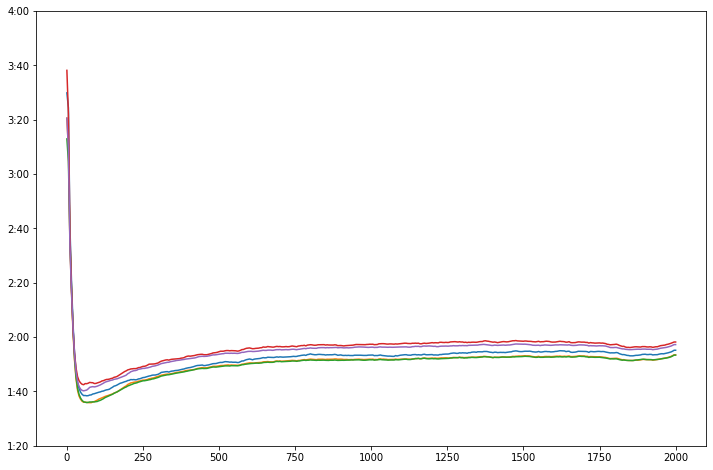

In [380]:
pred_pace, pred_pace_cov = \
    predicter.predict_pace(race_pace.T, distance=250)

f, ax = plt.subplots(figsize=(12, 8))
ax.plot(pred_pace)

utils.format_yaxis_splits(ax)

In [151]:
preds = predict_race_pace_times(distances, live_data.iloc[:200], K, noise=10)

In [202]:
race_pace = predict.calc_boat_pace(live_data)
times = predict.calc_boat_time(live_data)
pace, time = race_pace.iloc[0], times.iloc[0]

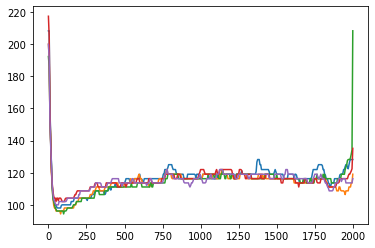

In [203]:
plt.plot(race_pace.T)

In [372]:
race_pace.T.shape

(401, 5)

In [387]:
np.diff(predicter.distances) 

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [371]:
predicter.get_linear_pace_predicter(50).shape

(11, 401)

In [ ]:
def pred_finish_time(pred_distances, pace, K, noise=0.1, start_distance=250):
    x = pred_distances
    X = pace.index
    
    kxx = K.loc[x, x]
    L = pd.DataFrame(
        np.linalg.cholesky(
            K.loc[X, X] + np.eye(len(X)) * noise
        ),
        index=K.index,
        columns=K.columns, 
    )

    n = X.searchsorted(start_distance)
    pred_finish = pace.loc[start_distance:].copy()
    pred_finish_std = pace.iloc[start_distance:].copy()
    pred_finish.name = 'predicted_finish_time'
    pred_finish_std.name = 'predicted_finish_time_std'
    
    for d in pred_finish.index:
        X = pace.loc[:d].index
        kxX = K.loc[x, X]
        LXX = L.loc[X, X]
        pred_pace = kxX.dot(linalg.cho_solve((LXX, True), pace.loc[:d]))
        Kkh = linalg.solve_triangular(
            LXX, kxX.T, lower=True
        )
        pred_pace_cov = kxx - Kkh.T.dot(Kkh)
        deltam = np.diff(x)    
        deltam = np.r_[deltam, deltam[0]]/500
        pred_finish[d] = pred_pace.dot(deltam)
        pred_finish_std[d] = deltam.dot(pred_pace_cov).dot(deltam)

    return pred_finish, pred_finish_std

In [281]:
gp_coefs = {}
x = distances
for d in tqdm(pred_finish.index):
    X = pace.loc[:d].index
    kxX = K.loc[x, X]
    LXX = L.loc[X, X]
    A = linalg.cho_solve((LXX, True), kxX.T)
    Kkh = linalg.solve_triangular(
        LXX, kxX.T, lower=True
    )
    pred_pace_cov = kxx - Kkh.T.dot(Kkh)
    deltam = np.diff(x)    
    deltam = np.r_[deltam, deltam[0]]/500
    finish_std = deltam.dot(pred_pace_cov).dot(deltam)**0.5
    gp_coefs[d] = (A.dot(deltam), finish_std)
    

  0%|          | 0/351 [00:00<?, ?it/s]

In [291]:
    pred_finish = race_pace.loc[:, start_distance:].T.copy()
    pred_finish_std = race_pace.loc[:, start_distance:].T.copy()
    
    for d in pred_finish.index:
        A, std = gp_coefs[d]
        X = pace.loc[:d].index
        kxX = K.loc[x, X]
        LXX = L.loc[X, X]
        pred_finish.loc[d] = A.dot(race_pace.loc[:, :d].T)
        pred_finish_std.loc[d] = std

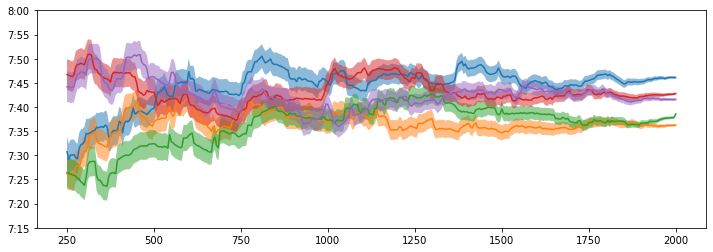

In [295]:

f, ax = plt.subplots(figsize=(12, 4))
ax.plot(pred_finish.index, pred_finish)
for cnt in pred_finish.columns:
    ax.fill_between(
        pred_finish.index, 
        pred_finish[cnt] - pred_finish_std[cnt]**0.5,
        pred_finish[cnt] + pred_finish_std[cnt]**0.5,
        alpha=0.5
    )

yticks = ax.get_yticks()
ax.set_yticks(yticks)
ax.set_yticklabels(
    [utils.format_totalseconds(s, False) for s in yticks]
);

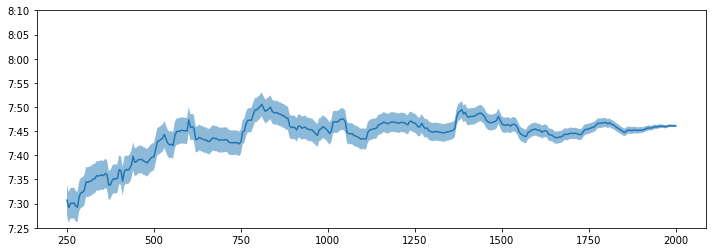

In [284]:
    start_distance = 250
    pred_finish = pace.loc[start_distance:].copy()
    pred_finish_std = pace.iloc[start_distance:].copy()
    pred_finish.name = 'predicted_finish_time'
    pred_finish_std.name = 'predicted_finish_time_std'
    
    for d in pred_finish.index:
        A, std = gp_coefs[d]
        X = pace.loc[:d].index
        kxX = K.loc[x, X]
        LXX = L.loc[X, X]
        pred_finish[d] = A.dot(pace.loc[:d])
        pred_finish_std[d] = std
    
f, ax = plt.subplots(figsize=(12, 4))
ax.plot(pred_finish.index, pred_finish)
ax.fill_between(
    pred_finish.index, 
    pred_finish - pred_finish_std**0.5,
    pred_finish + pred_finish_std**0.5,
    alpha=0.5
)

ax.set_ylim(
    pred_finish.iloc[-1] - 20,
    pred_finish.iloc[-1] + 20,
)

yticks = ax.get_yticks()
ax.set_yticks(yticks)
ax.set_yticklabels(
    [utils.format_totalseconds(s, False) for s in yticks]
);

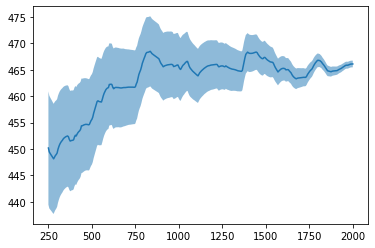

In [272]:
pred_finish, pred_finish_std = predict.pred_finish_time(
    distances, pace, K, noise=10, start_distance=250
)

plt.plot(pred_finish.index, pred_finish)
plt.fill_between(
    pred_finish.index, 
    pred_finish - pred_finish_std**0.5,
    pred_finish + pred_finish_std**0.5,
    alpha=0.5
)

In [ ]:


pred_finish, pred_finish_std = predict.pred_finish_time(
    distances, pace, K, noise=10, start_distance=250
)

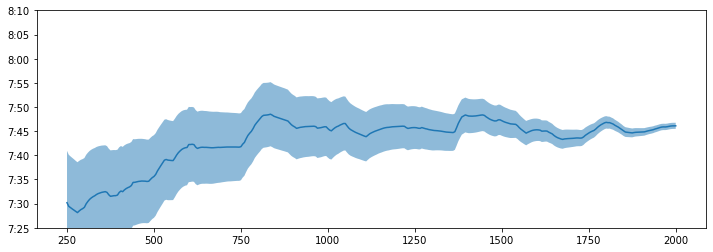

In [273]:
f, ax = plt.subplots(figsize=(12, 4))

plt.plot(pred_finish.index, pred_finish)
plt.fill_between(
    pred_finish.index, 
    pred_finish - pred_finish_std**0.5,
    pred_finish + pred_finish_std**0.5,
    alpha=0.5
)

ax.set_ylim(
    pred_finish.iloc[-1] - 20,
    pred_finish.iloc[-1] + 20,
)

yticks = ax.get_yticks()
ax.set_yticks(yticks)
ax.set_yticklabels(
    [utils.format_totalseconds(s, False) for s in yticks]
);

In [246]:
pred_finish.map(utils.format_totalseconds)

distance
250     07:30.19
255     07:29.44
260     07:29.16
265     07:28.90
270     07:28.65
          ...   
1980    07:45.98
1985    07:46.05
1990    07:46.09
1995    07:46.10
2000    07:46.10
Name: predicted_finish_time, Length: 351, dtype: object

In [245]:
pred_deltas = pd.to_timedelta(pred_finish, unit='seconds')
pred_deltas

distance
250    0 days 00:07:30.197408885
255    0 days 00:07:29.445791617
260    0 days 00:07:29.168925665
265    0 days 00:07:28.909780195
270    0 days 00:07:28.656523758
                  ...           
1980   0 days 00:07:45.987378001
1985   0 days 00:07:46.055661302
1990   0 days 00:07:46.092595113
1995   0 days 00:07:46.101535468
2000   0 days 00:07:46.106208648
Name: predicted_finish_time, Length: 351, dtype: timedelta64[ns]

In [225]:
import datetime

In [228]:
td = pred_deltas.iloc[0]
td

Timedelta('0 days 00:07:30.197408885')

In [243]:
from datetime import timedelta

def format_totalseconds(seconds):
    return format_timedelta(timedelta(seconds=seconds))

def format_timedelta(timedelta):
    mins = td.seconds // 60
    secs = td.seconds - mins * 60
    hundredths = td.microseconds // 10_000
    return f"{mins:02d}:{secs:02d}.{hundredths:02d}"
    
format_timedelta(td)

'07:30.19'

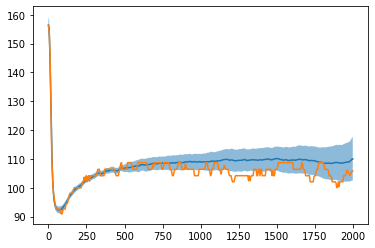

In [96]:
i = 100
x = X[0]

ff = meanX * meanX.T
K = pd.DataFrame(
    (ff + cov), 
    index=distances, columns=distances
)
pace = pd.Series(x, index=distances)
pred, pred_cov, pred_times, pred_times_cov = \
    predict.predict_pace_time(distances, pace.iloc[:i], K, noise=10.)


pred_std = pred_cov.values.diagonal()**0.5
pred_time_std = pred_times_cov.diagonal()**0.5

plt.plot(pred)
plt.fill_between(
    distances, 
    pred - pred_std,
    pred + pred_std,
    alpha=0.5
)
plt.plot(distances, x)

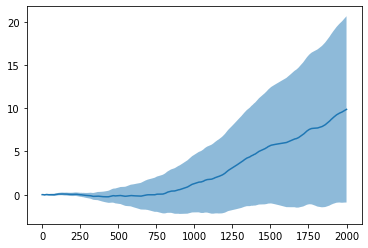

In [79]:
times = x.cumsum()/100
plt.plot(distances, pred_times - times)
plt.fill_between(
    distances, 
    pred_times - times - pred_time_std,
    pred_times - times + pred_time_std,
    alpha=0.5
)

In [85]:
100**3/90**3, 80**3/70**3

(1.3717421124828533, 1.4927113702623906)

## Boat class specific GPs 

In [80]:
from scipy import linalg

In [81]:
sel_boat_pace = boat_pace.loc[max_variation < 30]
sel_race_ids = sel_boat_pace.index.get_level_values(0).unique()
race_boat_class = live_races.loc[sel_race_ids].DisplayName_boat_class
grouped_live_races = race_boat_class.groupby(race_boat_class)

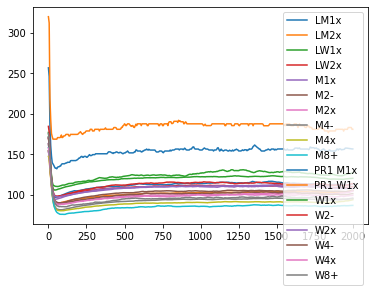

In [82]:
boat_mean_pace = {}
boat_shifted_pace = {}

for boat_class, boat_df in grouped_live_races:
    class_boat_pace = sel_boat_pace.loc[boat_df.index]
    boat_mean_pace[boat_class] = class_boat_pace.mean(0)
    boat_shifted_pace[boat_class] = (
        class_boat_pace - class_boat_pace.mean(0)
    )
#     break
    
for boat_class, mean_pace in boat_mean_pace.items():
    plt.plot(distances, mean_pace, label=boat_class)
    
plt.legend()

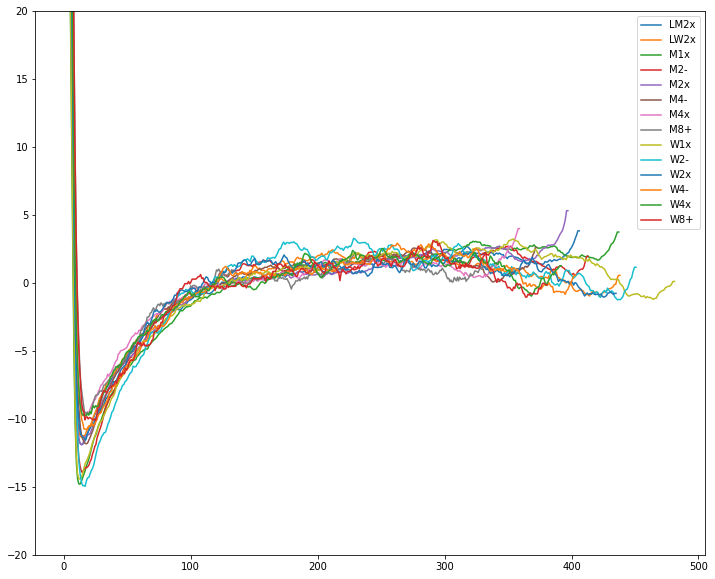

In [83]:
f, ax = plt.subplots(figsize=(12, 10))


for boat_class, mean_pace in boat_mean_pace.items():
    if boat_class not in ('LW1x', 'LM1x', 'PR1 M1x', 'PR1 W1x'):
        plt.plot(mean_pace.cumsum()/100, 
                 mean_pace - (mean_pace[:]).mean(), 
                 label=boat_class)
    
plt.ylim(-20, 20)
plt.legend()

In [86]:
mean_pace

distance
0       175.665937
5       170.722031
10      147.077651
15      133.669552
20      118.313594
           ...    
1980     94.917997
1985     94.958651
1990     94.900416
1995     94.842182
2000     94.842182
Length: 401, dtype: float64

In [92]:
boat_mpace = pd.concat(boat_mean_pace,axis=1)
boat_mpace - boat_mpace.mean(0)

,LM1x,LM2x,LW1x,LW2x,M1x,M2-,M2x,M4-,M4x,M8+,PR1 M1x,PR1 W1x,W1x,W2-,W2x,W4-,W4x,W8+
distance,,,,,,,,,,,,,,,,,,
0,41.459582,52.748962,47.314524,60.784571,54.024667,59.628918,53.497572,61.611156,57.722114,73.133969,103.224304,135.721044,56.930946,71.979567,62.260838,69.275546,59.595371,80.696600
5,36.319727,47.211511,40.384921,52.800242,44.985519,52.967959,49.430677,58.744768,54.922654,71.455591,92.741239,127.991576,46.037658,65.070760,54.517683,63.537008,56.048092,75.752694
10,23.566684,30.284362,23.215245,30.013599,26.067510,37.083944,34.945240,44.488921,41.829067,57.537326,31.920080,34.054418,23.308938,37.978022,33.991313,44.723419,40.258096,52.108314
15,12.181623,19.314991,11.150245,19.164325,14.146512,23.650582,23.436066,31.870683,30.864713,44.070946,7.246166,8.499900,11.501493,23.082117,22.346361,31.164594,28.919719,38.700216
20,1.846767,9.479311,-0.381910,9.005835,3.728998,11.220791,12.526756,19.468336,19.828989,30.196682,-5.764717,-8.842528,0.809942,9.052305,11.405716,18.183517,18.182208,23.344257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,-0.209909,2.981684,1.677781,-0.107846,2.958557,1.021342,3.897492,1.792386,3.159032,1.308766,3.244526,-1.559794,-0.233631,0.245553,-0.648833,-0.082219,0.972670,-0.051340
1985,0.229997,3.272812,1.631337,-0.100956,3.167482,1.208976,4.237833,2.076080,3.449127,1.369315,3.098005,-1.559794,-0.228655,0.384828,-0.746562,0.147661,1.022638,-0.010686
1990,0.425995,3.521478,1.993029,0.333037,3.454471,1.574960,4.641297,2.228899,3.713207,1.413629,2.951484,-1.559794,-0.104954,0.838574,-0.835759,0.373299,1.167175,-0.068921


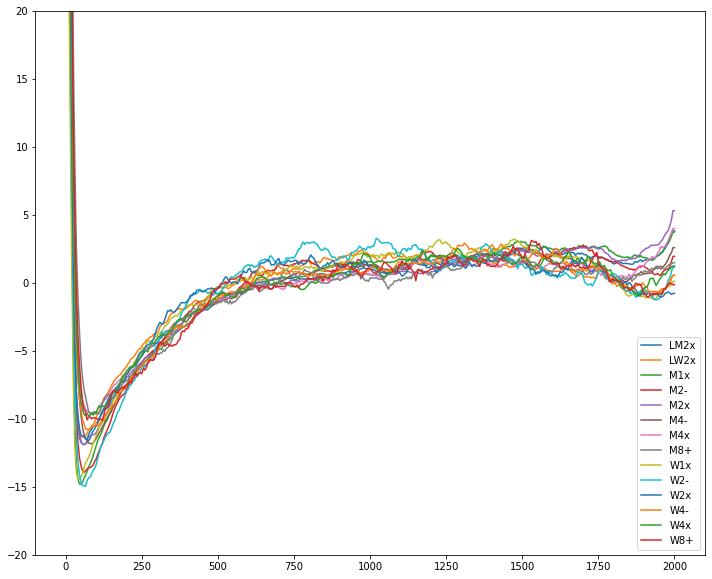

In [87]:
f, ax = plt.subplots(figsize=(12, 10))

for boat_class, mean_pace in boat_mean_pace.items():
    if boat_class not in ('LW1x', 'LM1x', 'PR1 M1x', 'PR1 W1x'):
        plt.plot(mean_pace.index, 
                 mean_pace - (mean_pace[:]).mean(), 
                 label=boat_class)
    
plt.ylim(-20, 20)
plt.legend()

In [164]:
shifted_pace = pd.concat(boat_shifted_pace)
cov = shifted_pace.cov()

In [165]:
boat_mean_K = {
    boat_class: pd.DataFrame(
        mean_pace.values[:, None] * mean_pace.values[None, :],
        index=mean_pace.index,
        columns=mean_pace.index, 
    )
    for boat_class, mean_pace in boat_mean_pace.items()
}
boat_K = {
    boat_class: cov + meanK
    for boat_class, meanK in boat_mean_K.items()
}

In [178]:
# boat_L = {
#     boat_class: pd.DataFrame(
#         np.linalg.cholesky(
#             cov + meanK 
#         ),
#         index=mean_pace.index,
#         columns=mean_pace.index, 
#     ) 
#     for boat_class, meanK in boat_mean_K.items()
# }

LinAlgError: Matrix is not positive definite

In [90]:
def predict(pred_distances, pace, K, L=None):
    x = pred_distances
    X = pace.index
    
    kxx = K.loc[x, x]
    kxX = K.loc[x, X]
    KXX = K.loc[X, X]
    if L is None:
        LXX = pd.DataFrame(
            np.linalg.cholesky(KXX),
            index=mean_pace.index,
            columns=mean_pace.index, 
        ) 
    else:
        L = L.loc[X,X]
    
    pred_pace = kxX.dot(linalg.cho_solve((L, True), pace))
    Kkh = linalg.solve_triangular(
        L, kxX.T, lower=True
    )
    pred_cov = kxx - Kkh.T.dot(Kkh)
    return pred_pace, pred_cov
    
    

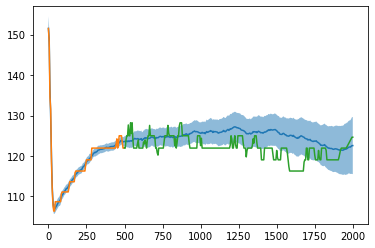

In [183]:
i = 100
pace = sel_boat_pace.iloc[0, :]
race_id, cnt = pace.name
boat_class = race_boat_class[race_id]
pred_distances = distances[:]
K = boat_K[boat_class]
# L = boat_L[boat_class]

pred, pred_cov, pred_times, pred_times_cov = \
    predict(pred_distances, pace.iloc[:i], K, noise=10.)
pred_std = pred_cov.values.diagonal()**0.5
pred_time_std = pred_times_cov.diagonal()**0.5

plt.plot(pred)
plt.fill_between(
    pred_distances, 
    pred - pred_std,
    pred + pred_std,
    alpha=0.5
)
plt.plot(pace.iloc[:i])
plt.plot(pace.iloc[i:])

## GP smoothing

In [ ]:
K = (ff + cov)
Kfull = K + np.eye(len(ff)) * 100
L = np.linalg.cholesky(Kfull)

X_smoothed = np.vstack([
    K.dot(cho_solve((L, True), x))
    for x in X
])
Xsmean = X_smoothed.mean(0, keepdims=True)
cov = np.cov((X_smoothed - Xsmean).T)
ff = Xsmean * Xsmean.T

plt.contour(
    distances, distances,
    cov,
    np.quantile(cov, np.linspace(0, 1, 11)[1:-1])
)

In [ ]:
np.cov?

# Derviative regularised Factor Analysis 

In [ ]:
i = 20
x = X[200]

K = (ff + cov)
Kfull = K + np.eye(len(ff)) * 100
L = np.linalg.cholesky(Kfull)

x_smoothed = K.dot(cho_solve((L, True), x))

plt.plot(distances, x)
plt.plot(distances, x_smoothed)

In [ ]:
W, F = predict.fit_factor_analysis_regularised(X, 5)
plt.plot(ds, W.dot(F).T);